# **GUNITA - Programming Assignment 2**
<h2>Linear Regression</h2>

## Loading the Dataset

In [1]:
!pip install -q ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
energy_efficiency = fetch_ucirepo(id=242)

Loading the necessary modules for training, visualization, and EDA.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Exploratory Data Analysis

This was performed to gain coarse insights of what can we extract from the dataset.

In [3]:
print(f'Length:     {len(energy_efficiency.data.features)}')
print(f'Dimensions: ({len(energy_efficiency.variables)},{len(energy_efficiency.data.features)})')
print(f'Missing:    {energy_efficiency.variables.missing_values.unique().sum()}')
print(f'Features:   {(energy_efficiency.variables.role == "Feature").sum()}')
print(f'Labels:     {(energy_efficiency.variables.role == "Target").sum()}')

variables = energy_efficiency.variables.description.to_list()
types = energy_efficiency.variables.type.to_list()

Length:     768
Dimensions: (10,768)
Missing:    no
Features:   8
Labels:     2


The dataset contains 768 data points, all of which are complete, with no missing values in either the features or labels. It includes 10 variables: 8 features and 2 labels. The metadata for these variables is provided below. **The objective is to identify the variables that influence heating and cooling loads, along with their respective weights.**

In [4]:
energy_efficiency.variables[['name', 'role' ,'type' , 'description']]

,name,role,type,description
0,X1,Feature,Continuous,Relative Compactness
1,X2,Feature,Continuous,Surface Area
2,X3,Feature,Continuous,Wall Area
3,X4,Feature,Continuous,Roof Area
4,X5,Feature,Continuous,Overall Height
5,X6,Feature,Integer,Orientation
6,X7,Feature,Continuous,Glazing Area
7,X8,Feature,Integer,Glazing Area Distribution
8,Y1,Target,Continuous,Heating Load
9,Y2,Target,Continuous,Cooling Load


Since the `energy_efficiency` dataset includes metadata, we were able to acquire it.

In [5]:
df = pd.concat([energy_efficiency.data.features, energy_efficiency.data.targets], axis=1)

Plot multiple scatterplots to see any trends with the features x labels.

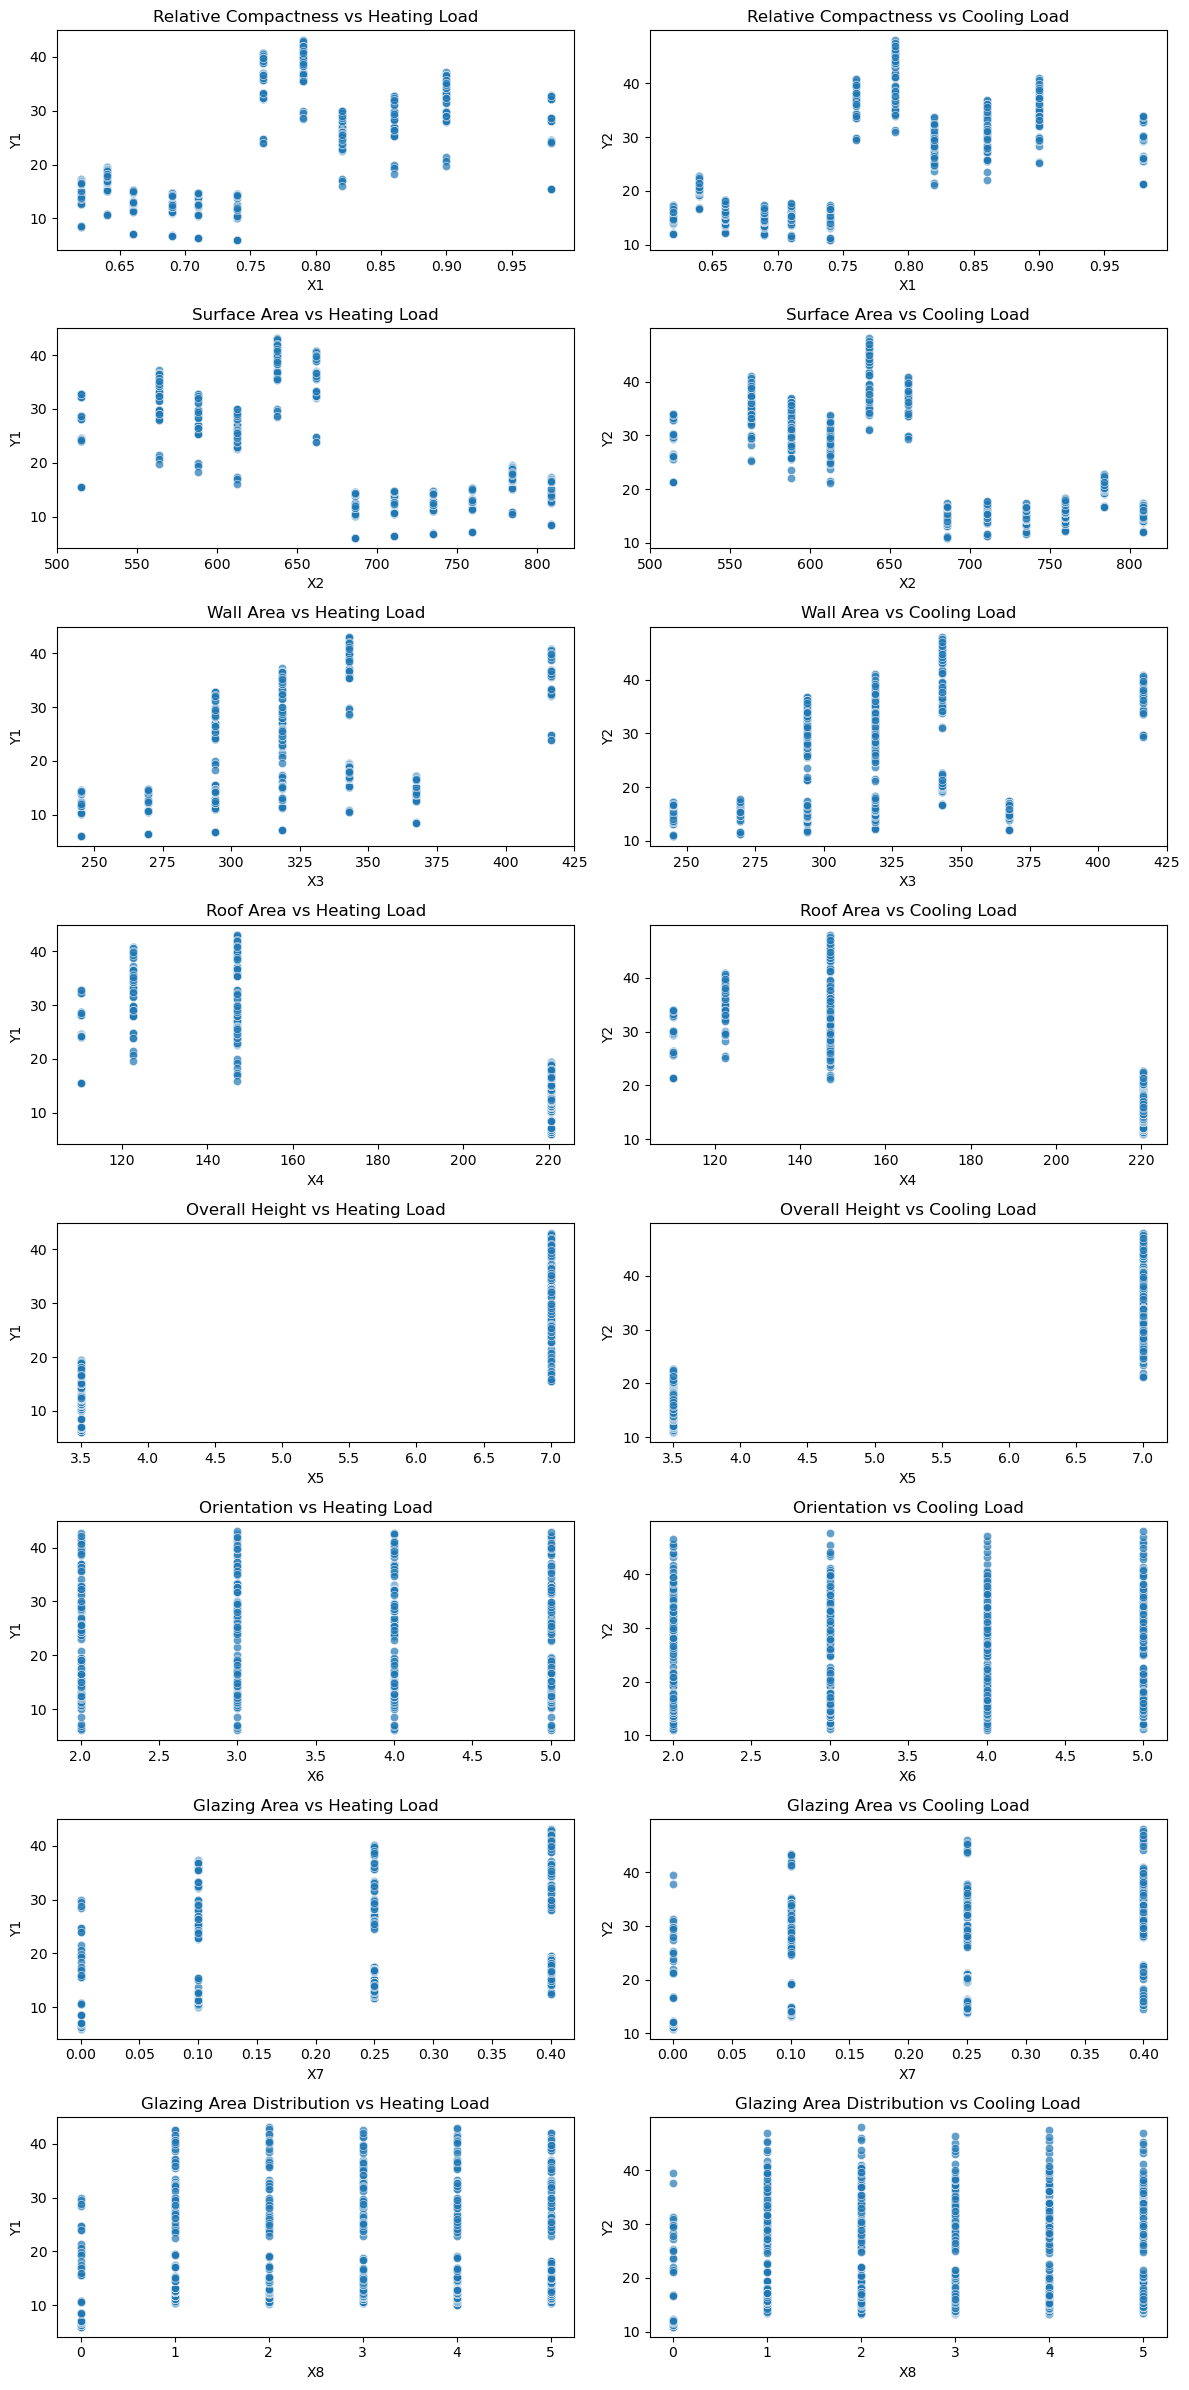

In [6]:
fig, axes = plt.subplots(8, 2, figsize=(12, 24))

for i in range(8):
    feature = 'X' + str((i+1))
    feature_name = energy_efficiency.variables[energy_efficiency.variables.name == feature].description[i]

    sns.scatterplot(data=df, x=feature, y='Y1', ax=axes[i, 0], alpha=0.7)
    axes[i, 0].set_title(f'{feature_name} vs Heating Load')

    sns.scatterplot(data=df, x=feature, y='Y2', ax=axes[i, 1], alpha=0.7)
    axes[i, 1].set_title(f'{feature_name} vs Cooling Load')

plt.tight_layout()
plt.show()

Although the variables are continuous, they are bucketized into discrete values. As a result, a scatterplot may not be the most suitable visualization for identifying trends in the dataset; instead, a line plot would be more appropriate.

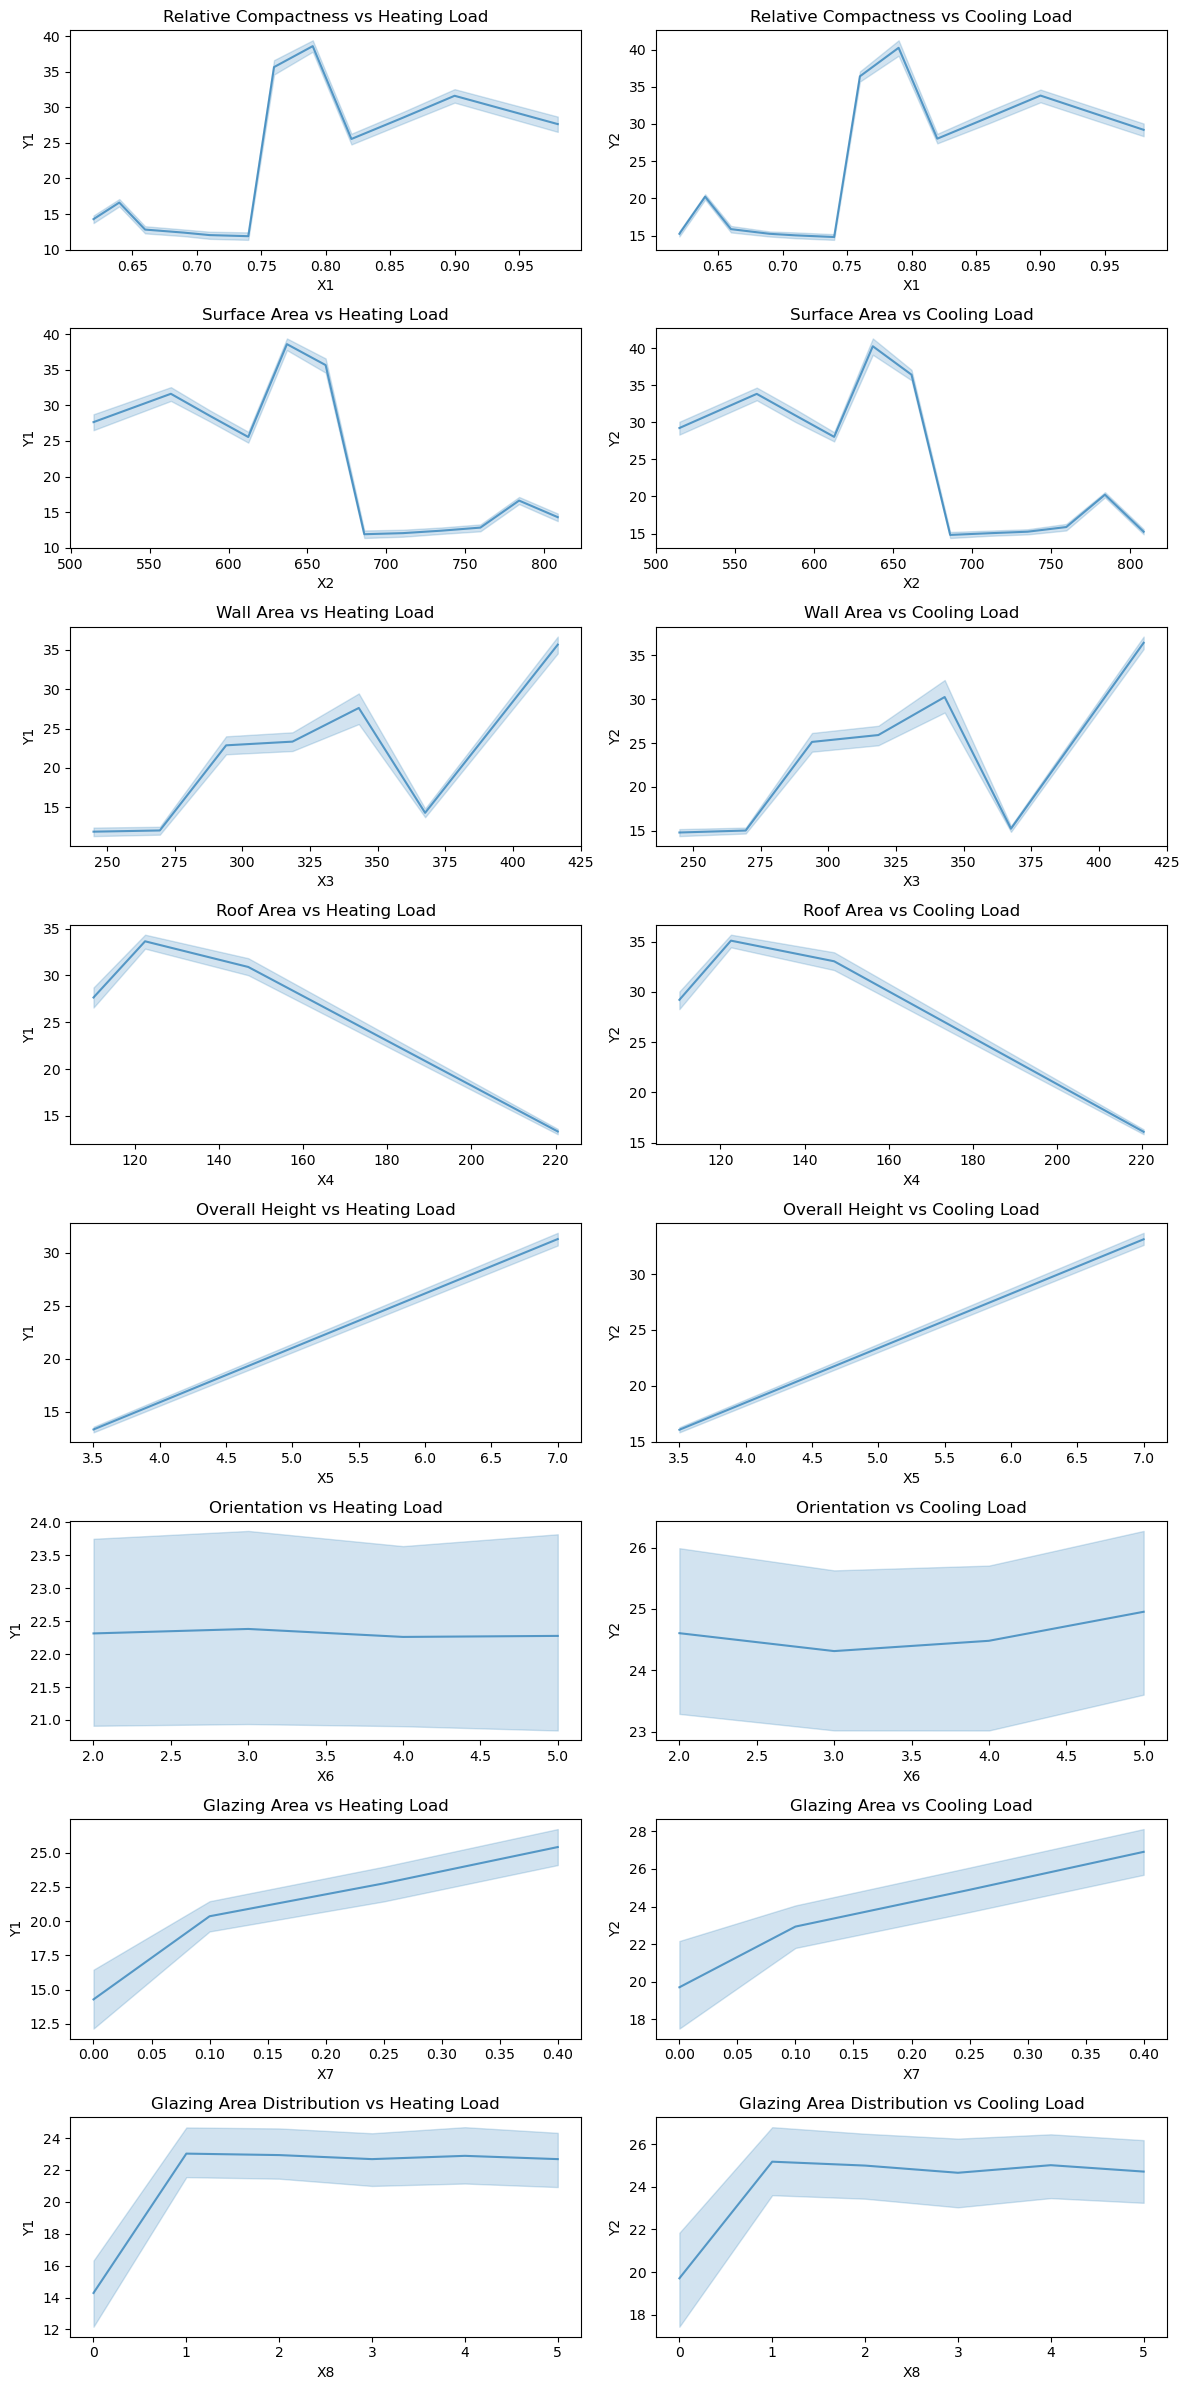

In [7]:
fig, axes = plt.subplots(8, 2, figsize=(12, 24))

for i in range(8):
    feature = 'X' + str((i+1))
    feature_name = energy_efficiency.variables[energy_efficiency.variables.name == feature].description[i]

    sns.lineplot(data=df, x=feature, y='Y1', ax=axes[i, 0], alpha=0.7)
    axes[i, 0].set_title(f'{feature_name} vs Heating Load')

    sns.lineplot(data=df, x=feature, y='Y2', ax=axes[i, 1], alpha=0.7)
    axes[i, 1].set_title(f'{feature_name} vs Cooling Load')

plt.tight_layout()
plt.show()

## Model Training

During this part, the main focus was on predicting the heating load based on the features provided. We utilized multiple linear regression regularized with ridge regression. The goal of this training process was to determine the optimal hyperparameter alpha value for ridge regression.

### Step 1. Splitting the data

We splitted the data into 60% training, 20% testing, and 20% validation.

In [8]:
from sklearn.model_selection import train_test_split

x = energy_efficiency.data.features
y = energy_efficiency.data.targets.Y1

# Get 60% training and 40% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=69)

# Further split 40% testing to 20% validation and 20% siloed testing
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=420)

print(f"Traning size: {len(x_train)}")
print(f"Validation size: {len(x_val)}")
print(f"Test: {len(y_test)}")

Traning size: 460
Validation size: 154
Test: 154


### Step 2. Ridge Regularization

Ten different ridge regularization values was selected and evaluated the accuracy of each on the validation set. To streamline the process, a function that applies ridge regularization to a given set of features was developed. Additionally, another function to evaluate the model's performance was implemented.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def ridge_lr(alpha,
             training_features=x_train,
             training_labels=y_train,
             test_features=x_val,
            ):
    """ Perform linear regression with ridge regularization. """
    
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(training_features, training_labels)
    predictions = model_ridge.predict(test_features)

    
    return predictions, model_ridge

In [10]:
predictions, model = ridge_lr(1e-2, test_features=x_test)


In [12]:
def eval_lr(truth, predictions: list, names=[""]):
    """ Evaluate linear regression models with R2, MSE, RMSE, and NMSE. """

    r2s, mses, rmses, nmses = [], [], [], []
    for prediction in predictions:
        r2 = r2_score(truth, prediction)
        mse = mean_squared_error(truth, prediction)
        rmse = np.sqrt(mse)
        nmse = mse / np.var(truth) 
        r2s.append(r2)
        mses.append(mse)
        rmses.append(rmse)

    results = pd.DataFrame({
        "r2": r2s,
        "mse": mses,
        "rmse": rmses,
    }, index=names)

    return results

The model was initially trained using ridge regression with the following alpha values. The pattern of these values resembles the sigmoid/logistic function.

                r2        mse      rmse
0.0001    0.926392   7.484246  2.735735
0.001     0.926373   7.486114  2.736076
0.01      0.926113   7.512634  2.740919
0.1       0.923998   7.727636  2.779863
1.0       0.922025   7.928203  2.815707
10.0      0.905132   9.645832  3.105774
100.0     0.860443  14.189727  3.766925
1000.0    0.828971  17.389706  4.170097
10000.0   0.817970  18.508235  4.302120
100000.0  0.812748  19.039209  4.363394


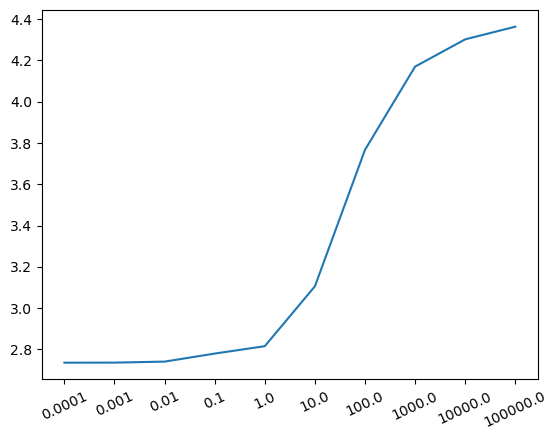

In [13]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]

predictions = []
for alpha in alphas:
    prediction, _ = ridge_lr(alpha)
    predictions.append(prediction)

results = eval_lr(y_val, predictions, names=[f"{alpha}" for alpha in alphas])
print(results)
plt.xticks(rotation=25)
plt.plot(results.rmse);

### Step 3. Final Evaluation

We evaluated the optimal value for the ridge regularization hyperparameter and determined that the best model has an alpha of 0.01, achieving an R2 score of 0.920539.

In [14]:
predictions, model = ridge_lr(1e-2, test_features=x_test)

results = eval_lr(y_test, [predictions])
print(results)

        r2       mse      rmse
  0.920539  8.166739  2.857751


The test set results are comparable to those of the validation set, indicating that this is likely the best ridge regression model for our dataset.

### Step 4. Post Training Analysis

We analyzed the best model's coefficients and intercept, as well as the training, validation, and test accuracies.

In [15]:
coefficients = np.argsort(np.abs(model.coef_))[::-1]
features = [f"X{i+1}: {round(model.coef_[i], 2)}" for i in coefficients]

print("Model parameters:")
for feature in features:
    print(feature)
print(f"Intercept: {round(model.intercept_, 2)}")

Model parameters:
X1: -47.5
X7: 20.51
X5: 4.68
X8: 0.34
X6: -0.1
X2: -0.04
X4: -0.04
X3: 0.04
Intercept: 50.36


In [16]:
test_features = [x_val, x_test]

predictions = []
for test_feature in test_features:
    prediction, _ = ridge_lr(alpha=1e-2,
                             test_features=test_feature)
    predictions.append(prediction)

test_labels = [y_val, y_test]
names = ['validation','test      ']
for ix, test_label in enumerate(test_labels):
    print(eval_lr(test_label, [predictions[ix]], [names[ix]]))

                  r2       mse      rmse
validation  0.926113  7.512634  2.740919
                  r2       mse      rmse
test        0.920539  8.166739  2.857751


### Step 5. Identifying Best Features

From this analysis, we identified the top 5 most significant features of the linear regression model. These features are X1, X7, X5, X8, and X6, which contribute the most to the model's predictions.

In [17]:
top_5 = np.argsort(np.abs(model.coef_))[::-1][:5]
top_5_names = [f"X{i+1}" for i in top_5]
features = [f"{name}: {round(model.coef_[coef], 2)}" for name, coef in zip(top_5_names,top_5)]

print("Top 5 parameters:")
for feature in features:
    print(feature)

Top 5 parameters:
X1: -47.5
X7: 20.51
X5: 4.68
X8: 0.34
X6: -0.1


### Step 6. Feature Ablation
Lastly, we trained the original dataset using the top 5 best features using the function we created earlier.


In [18]:
nx = energy_efficiency.data.features[top_5_names]
ny = energy_efficiency.data.targets.Y1

# Get 60% training and 40% testing
nx_train, nx_test, ny_train, ny_test = train_test_split(nx, ny, test_size=0.4, random_state=69)

# Further split 40% testing to 20% validation and 20% siloed testing
nx_val, nx_test, ny_val, ny_test = train_test_split(nx_test, ny_test, test_size=0.5, random_state=420)

test_features = [nx_val, nx_test]


                r2         mse       rmse
0.0001    0.919049    8.230844   2.868945
0.001     0.919045    8.231271   2.869019
0.01      0.919002    8.235658   2.869784
0.1       0.918470    8.289755   2.879193
1.0       0.909559    9.195736   3.032447
10.0      0.861265   14.106119   3.755811
100.0     0.810652   19.252349   4.387750
1000.0    0.656651   34.910589   5.908518
10000.0   0.168574   84.536711   9.194385
100000.0  0.003924  101.277857  10.063690


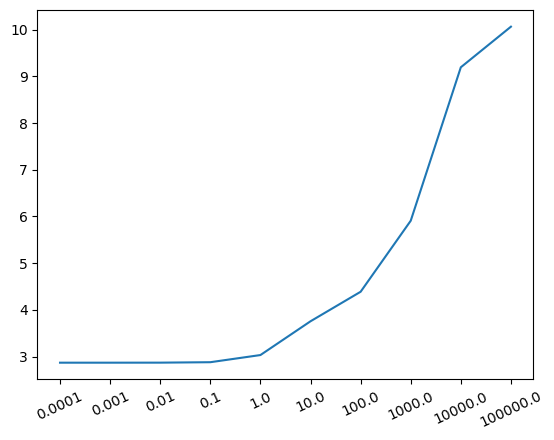

In [19]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]

predictions = []
for alpha in alphas:
    prediction, _ = ridge_lr(alpha, training_features=nx_train, training_labels=ny_train, test_features=nx_val)
    predictions.append(prediction)

results = eval_lr(ny_val,  predictions, names=[f"{alpha}" for alpha in alphas])
print(results)
plt.xticks(rotation=25)
plt.plot(results.rmse);

In [20]:
predictions = []
for test_feature in test_features:
    prediction, _ = ridge_lr(alpha=1e-4,
                             training_features=nx_train,
                             training_labels=ny_train,
                             test_features=test_feature)
    predictions.append(prediction)

test_labels = [ny_val, ny_test]
names = ['validation','test      ']
for ix, test_label in enumerate(test_labels):
    print(eval_lr(test_label, [predictions[ix]], [names[ix]]))

                  r2       mse      rmse
validation  0.919049  8.230844  2.868945
                  r2       mse     rmse
test        0.907583  9.498233  3.08192


## Questions

#### Guide Question 1:
**What is the impact of removing certain features on the model’s performance?**

We observe a less performant model, which is expected when using only the most important features. This often results in a simpler, less complex model. This also explains why less regularization is needed compared to training with all the features. By removing some features, we lose some information that may not be crucial but still contributes to the overall prediction. This approach is commonly used in large-scale machine learning applications, where features can have very high dimensions, particularly in deep learning. Reducing the number of features helps to decrease the dimensionality of the input data, which in turn reduces both training and inference times.

#### Guide Question 2:
**Why is it necessary to split the data into training, validation, and testing sets? What could happen if this step is skipped?**

The training dataset allows the model to learn as many patterns as possible, but hyperparameter tuning or further training is needed to determine the best parameters. You can't use the test set for this because it would defeat the purpose of generalizing the model to unseen data. Doing so would introduce bias, as you would be artificially increasing the model's accuracy based on the test set. After validation, the model should be tested on an isolated, unseen dataset, called the testing set. The performance on this testing set serves as a true benchmark for the model's generalizability.

#### Guide Question 3:
**How can the generalization ability of the model be assessed using the test data? What steps would you take to ensure the model generalizes well to unseen data?**

To assess the generalization ability of a model using test data, you evaluate its performance on data that was not seen during training or validation. The test data provides insight into whether the model is overfitted or underfitted to the training and validation sets, highlighting potential issues such as training-serving skew or data mismatch. To ensure the model generalizes well to unseen data, it’s crucial to choose the right model complexity that balances performance without overfitting. Techniques like cross-validation, feature encoding, normalization, and bucketizing can further enhance the model's performance. Additionally, the test data must remain completely isolated from the training and validation sets to avoid bias. Regularization methods such as L2 (ridge) or L1 (lasso) regression help reduce model complexity, while techniques like early stopping or dropout in deep learning prevent the model from becoming too specialized, ensuring it generalizes effectively to new, unseen data.